# Importing packages

In [157]:
import geopandas as gpd
import rasterio as rio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import contextily as ctx
from adjustText import adjust_text

# Read data

In [184]:
hazard_fn = 'HMaxProba_SudEst_274_100.asc'
vul_fn = 'CourbeDommages.csv'
exp_fn = 'Portefeuille.csv'

## Hazard

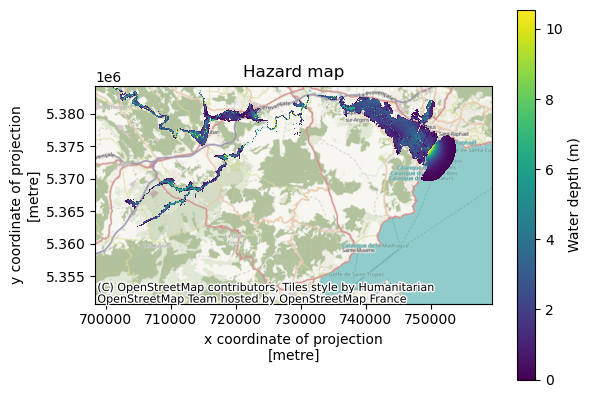

In [180]:
fig, ax = plt.subplots()
haz = xr.open_dataset(hazard_fn, engine='rasterio').squeeze().band_data
haz.rio.write_crs("EPSG:2154", inplace=True) #Assign CRS
haz.rio.reproject(dst_crs=3857).plot(ax = ax, cbar_kwargs={'label': 'Water depth (m)'})
ctx.add_basemap(ax)
ax.set_title('Hazard map')
plt.show()

## Vulnerability

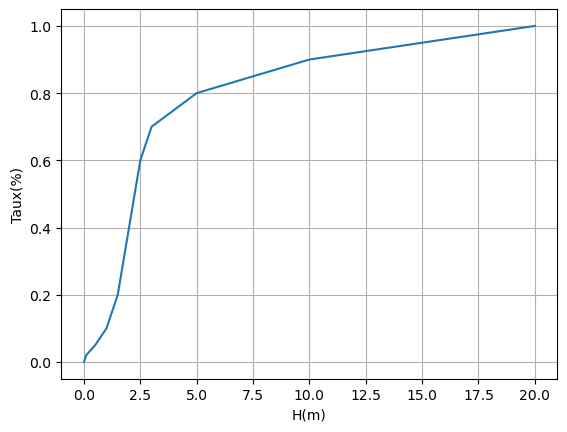

In [182]:
vul = pd.read_csv(vul_fn, delimiter=';')
vul['HauteurEau_M'] = vul['HauteurEau_M'].str.replace(',', '.').astype(float)
vul['TauxDestruction'] = vul['TauxDestruction'].str.replace(',', '.').astype(float)
plt.plot(vul['HauteurEau_M'],vul['TauxDestruction' ])
plt.xlabel('H(m)')
plt.ylabel('Taux(%)')
plt.grid(True)
plt.title('')
plt.show()

## Exposure

In [185]:
exp = pd.read_csv(exp_fn, encoding='ISO-8859-1', delimiter=';', index_col='ID')

from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(exp['X'], exp['Y'])]
exp = gpd.GeoDataFrame(exp, geometry=geometry)
# Set the CRS to EPSG:2154
exp.crs = "EPSG:2154" 

In [186]:
exp

,X,Y,Risque,Etage,Usage,ValeurAssuree,geometry
ID,,,,,,,
1,994335,6267603,Maison,2,Propriétaire,236021,POINT (994335.000 6267603.000)
2,994406,6267578,Villa,3,Propriétaire,531240,POINT (994406.000 6267578.000)
3,994431,6267425,Maison,1,Locataire,200069,POINT (994431.000 6267425.000)
4,994516,6267416,Appartement,4,Locataire,15032,POINT (994516.000 6267416.000)
5,995414,6267213,Entreprise,2,Propriétaire,1022606,POINT (995414.000 6267213.000)
6,994522,6266847,Maison,2,Propriétaire,260023,POINT (994522.000 6266847.000)
7,997958,6268622,Appartement,6,Propriétaire,54221,POINT (997958.000 6268622.000)
8,997987,6268622,Maison,1,Locataire,262654,POINT (997987.000 6268622.000)
9,998004,6268782,Maison,2,Propriétaire,287964,POINT (998004.000 6268782.000)


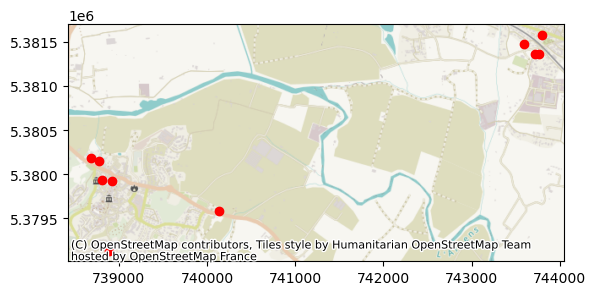

In [188]:
fig, ax = plt.subplots()
exp.to_crs(epsg = 3857).plot(ax = ax, color = 'red')
ctx.add_basemap(ax)

In [189]:
#export the exposure dataset as geojson to be explored in QGIS
exp.to_file('Portefeuille.geojson')

# Damage model

The following is a simplified damage model that attempts to estimate the cost based on the magnitude of the hazard and the vulnerability of the insured assets:

$$C_i = D_{\text{factor},i} \times V_i$$

Where:
- Cost per policy $$C_i$$
- Damage factor per policy $$D_{\text{factor},i}$$
- Value insured per policy $$V_i$$

The total damage is given by the sum of all costs per policy:

$$\text{Total damage} = \sum_{i} C_i$$


## Filter non damaged assets

In [192]:
# Create an empty list to store the points that fall within the raster
filtered_exp_list = []

# Loop through each point in the GeoDataFrame
for i, row in exp.iterrows():
    # Get the value of the raster at the point location
    val = haz.sel(x=row.geometry.x, y=row.geometry.y, method='nearest').values
    # If the value is not NaN, add the point to the list
    if not np.isnan(val):
        filtered_exp_list.append(row)

# Convert the list to a GeoDataFrame
filtered_exp = gpd.GeoDataFrame(pd.concat(filtered_exp_list, axis=1).T)

# Reset the index of the filtered GeoDataFrame
filtered_exp.reset_index(drop=True, inplace=True)

In [193]:
filtered_exp.crs = "EPSG:2154" 
filtered_exp.to_file('Portefeuille_exposed.geojson')

## Compute the corresponding hazard/asset

In [195]:
alea_values = [] #Create empy list to store hazard values
for i, row in exp.iterrows():
    alea_values.append(haz.sel(x=row.geometry.x, y=row.geometry.y, method='nearest').values)
exp['alea'] = np.round(alea_values,2)
exp.fillna(0, inplace=True)

/var/folders/th/dv8w1vd93zs5tp16yj9nld_w0000gn/T/ipykernel_77008/530036615.py:5: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.
  exp.fillna(0, inplace=True)


## Assign damage factor

In [196]:
#Interpolate the damage curve 
exp['taux'] = np.interp(exp['alea'], vul['HauteurEau_M'], vul['TauxDestruction'])

## Estimate cost per asset

In [197]:
exp['cout'] = np.round(exp['taux'] * exp['ValeurAssuree'],0)

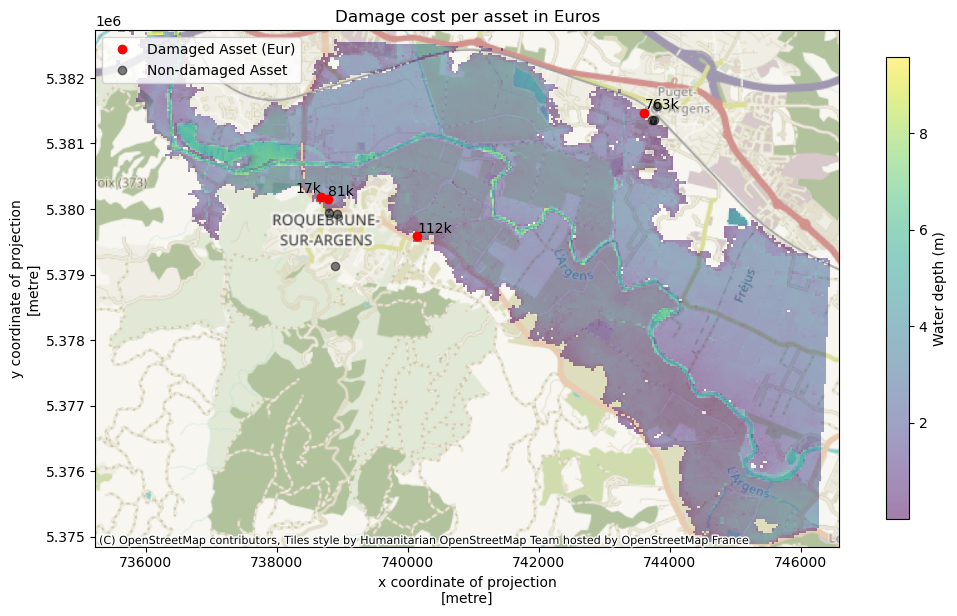

In [247]:
fig, ax = plt.subplots(figsize = (12,12))

# Convert CRS for plotting
exp_3857 = exp.to_crs(epsg=3857)

# Create empty lists for the legend
damaged = []
non_damaged = []

# Plot points with condition
for x, y, label in zip(exp_3857.geometry.x, exp_3857.geometry.y, exp_3857['cout']):
    if label != 0.0:  # Ignore null or zero values
        damaged += ax.plot(x, y, 'o', color='red')
        label = int(np.round(int(label)/1000))
        texts.append(ax.text(x, y,f'{label}k' ))

    else:
        non_damaged += ax.plot(x, y, 'o', color='black', alpha = 0.5)  # Grey color
        
# Clip and reproject haz layer
haz_clipped = haz.rio.clip_box(minx=0.992e6, miny=6.264e6, maxx=1.0e6, maxy=haz.rio.bounds()[3])
haz_clipped.rio.reproject(dst_crs=3857).plot(ax = ax, cbar_kwargs={'label': 'Water depth (m)', 'shrink': 0.5},
                                            alpha = 0.5)

# Adjust labels to minimize overlaps
adjust_text(texts)

# Add a basemap
ctx.add_basemap(ax)

ax.legend([damaged[0], non_damaged[0]], ['Damaged Asset (Eur)', 'Non-damaged Asset'], loc='upper left')
ax.set_title('Damage cost per asset in Euros')
# Save plot as PNG file with 300 dpi
plt.savefig('../Outputs/DamagePerAsset.png', dpi=300)

plt.show()


## Total damage

In [249]:
tot_damage = exp['cout'].sum()
print(f'Total estimated damage: {int(np.round(int(tot_damage)/1000))}k euros')

Total estimated damage: 973k euros
